In [1]:
#!/usr/bin/env python3
"""
Jorg Linelist Opacity Calculation Script
=======================================

Script to calculate line opacity using Jorg with a full linelist
covering the 5000-6000 Å range.
"""

import sys
import os
sys.path.insert(0, "/Users/jdli/Project/Korg.jl/Jorg/src")
import jax.numpy as jnp
import numpy as np
import time
import matplotlib.pyplot as plt
import re


In [2]:
from jorg.lines.linelist import load_korg_linelist
from jorg.lines.opacity import calculate_line_opacity_korg_method
from jorg.statmech.partition_functions import create_default_partition_functions
from jorg.statmech.species import Species
from jorg.lines.linelist import read_linelist
from jorg.lines.atomic_data import get_atomic_symbol
    

In [ ]:
# === STEP 1: Define atmospheric conditions ===
print("\n📊 Setting up atmospheric conditions...")

# Standard solar conditions for validation
temperature = 5780.0          # K (solar effective temperature)
electron_density = 1e14       # cm⁻³
hydrogen_density = 1e16       # cm⁻³
microturbulence_kms = 2.0     # km/s

print(f"  Temperature: {temperature:.0f} K")
print(f"  Electron density: {electron_density:.1e} cm⁻³")
print(f"  Hydrogen density: {hydrogen_density:.1e} cm⁻³")
print(f"  Microturbulence: {microturbulence_kms:.1f} km/s")

print("\n💡 These are the EXACT conditions used for Korg.jl validation")
print("   ensuring perfect parameter matching for comparison.")

# Note: We'll use chemical equilibrium results from Korg
# For now, use the chemical equilibrium electron density from Korg results
nₑ = 4.28e12  # cm⁻³ (from Korg chemical equilibrium calculation)

print(f"\n💡 Using chemical equilibrium electron density: {nₑ:.2e} cm⁻³")
print("   This matches the Korg Julia script chemical equilibrium results")

# Create number densities matching Korg chemical equilibrium results
number_densities = {}
number_densities['H_I'] = 9.23e15    # H I from Korg
number_densities['Fe_I'] = 2.73e09   # Fe I from Korg
number_densities['Fe_II'] = 2.64e11  # Fe II from Korg
number_densities['Ti_I'] = 9.01e05   # Ti I from Korg
number_densities['Ca_I'] = 4.54e06   # Ca I from Korg

print(f"\n📋 Chemical equilibrium number densities (from Korg):")
for species, density in number_densities.items():
    print(f"  {species}: {density:.2e} cm⁻³")

print(f"\n✅ Using chemical equilibrium results (matching Korg script)")
print("   This ensures identical physical conditions for comparison")


📊 Setting up atmospheric conditions...
  Temperature: 5780 K
  Electron density: 1.0e+14 cm⁻³
  Hydrogen density: 1.0e+16 cm⁻³
  Microturbulence: 2.0 km/s

💡 Using default nₑ = 1.00e+14 cm⁻³ (no chemical equilibrium)
   This matches the updated Korg Julia script methodology
   for simplified testing and debugging.

📋 Default number densities:
  H_I: 9.00e+15 cm⁻³
  Fe_I: 1.00e+11 cm⁻³
  Fe_II: 1.00e+10 cm⁻³
  Ti_I: 1.00e+09 cm⁻³
  Ca_I: 1.00e+10 cm⁻³

✅ Using simplified default values (matching Korg script)
   This bypasses complex chemical equilibrium calculations


In [4]:
# === STEP 2: Load linelist ===
print("\n🔬 Loading linelist...")
from pathlib import Path
from jorg.lines.linelist import read_linelist

# Use the same linelist as the Korg Julia script
linelist_paths = [
    # "/Users/jdli/Project/Korg.jl/data/linelists/vald_extract_stellar_solar_threshold001.vald",
    "/Users/jdli/Project/Korg.jl/test/data/linelists/5000-5005.vald"
]

linelist_file = None
for path in linelist_paths:
    if Path(path).exists():
        linelist_file = path
        break

if linelist_file is None:
    print("❌ No linelist file found. Using validation Fe I line.")
    # Use our validated single line for demonstration
    lines_data = [{
        'wavelength': 5434.5,
        'excitation_potential': 1.01,
        'log_gf': -2.12,
        'species': 'Fe I',
        'atomic_number': 26,
        'ionization': 0,
        'abundance': 1e-5,  # Default Fe abundance matching Korg script
        'atomic_mass': 55.845
    }]
    print("✅ Using validated Fe I 5434.5 Å line (default abundance)")
else:
    print(f"📁 Loading linelist from: {linelist_file}")
    print("📖 Reading VALD format linelist (matching Korg Julia script)...")
    
    # Load using VALD format reader
    linelist = read_linelist(linelist_file, format='vald')
    
    # Convert to the format expected by the opacity calculation
    lines_data = []
    for line in linelist.lines:
        # Get atomic number and ionization from species ID
        atomic_number = line.species // 100
        ionization = line.species % 100
        
        # Get element symbol for species name
        try:
            from jorg.lines.atomic_data import get_atomic_symbol
            element_symbol = get_atomic_symbol(atomic_number)
            if ionization == 0:
                species_name = f'{element_symbol} I'
            elif ionization == 1:
                species_name = f'{element_symbol} II'
            elif ionization == 2:
                species_name = f'{element_symbol} III'
            else:
                species_name = f'{element_symbol} {ionization + 1}'
        except:
            species_name = f'Z{atomic_number}_ion{ionization}'
        
        # Use default abundance based on species (matching Korg script)
        if atomic_number == 26:  # Fe
            default_abundance = 1e-5
        elif atomic_number == 22:  # Ti
            default_abundance = 1e-7
        elif atomic_number == 20:  # Ca
            default_abundance = 1e-6
        else:
            default_abundance = 1e-6  # Generic default
        
        lines_data.append({
            'wavelength': line.wavelength * 1e8,  # Convert cm to Å
            'excitation_potential': line.E_lower,  # Already in eV
            'log_gf': line.log_gf,
            'species': species_name,
            'atomic_number': atomic_number,
            'ionization': ionization,
            'abundance': default_abundance,  # Use default abundance matching Korg
            'atomic_mass': 55.845  # Default mass, could be improved
        })

print(f"✅ Loaded {len(lines_data)} lines")

# Show sample of lines
print("\n📋 Sample lines:")
for i, line in enumerate(lines_data[:5]):
    print(f"  {i+1}: {line['species']} {line['wavelength']:.2f} Å, log(gf)={line['log_gf']:.2f}, abundance={line['abundance']:.1e}")
if len(lines_data) > 5:
    print(f"  ... and {len(lines_data)-5} more lines")

print("\n💡 Using same VALD linelist as Korg Julia script with default abundances")
print("   This ensures consistent line data and abundances for comparison")


🔬 Loading linelist...
📁 Loading linelist from: /Users/jdli/Project/Korg.jl/test/data/linelists/5000-5005.vald
📖 Reading VALD format linelist (matching Korg Julia script)...
📖 Reading linelist: 5000-5005.vald
   Format: vald
   Wavelength unit: auto
   Found 15 data lines
   Successfully parsed 14 lines
✅ Loaded 14 lines

📋 Sample lines:
  1: Fe I 5001.90 Å, log(gf)=-1.74, abundance=1.0e-05
  2: La II 5002.25 Å, log(gf)=-0.77, abundance=1.0e-06
  3: Ti I 5002.29 Å, log(gf)=0.32, abundance=1.0e-07
  4: Fe I 5003.00 Å, log(gf)=-1.04, abundance=1.0e-05
  5: Ni I 5003.12 Å, log(gf)=-1.87, abundance=1.0e-06
  ... and 9 more lines

💡 Using same VALD linelist as Korg Julia script with default abundances
   This ensures consistent line data and abundances for comparison


In [ ]:
# === STEP 3: Create wavelength grid ===
print("\n📏 Creating wavelength grid...")

# Match the Korg Julia script wavelength range and resolution
λ_start, λ_stop = 5000.0, 6000.0  # Å (FULL RANGE like Korg script)
n_points = 10001  # High resolution matching Korg script
resolution = (λ_stop - λ_start) / (n_points - 1)

# Jorg uses JAX arrays directly in Angstroms
wavelengths = jnp.linspace(λ_start, λ_stop, n_points)

print(f"  Range: {λ_start:.1f} - {λ_stop:.1f} Å")
print(f"  Points: {n_points}")
print(f"  Resolution: {resolution:.3f} Å")

# Filter lines to this range
lines_in_range = [line for line in lines_data 
                  if λ_start <= line['wavelength'] <= λ_stop]

print(f"  Lines in range: {len(lines_in_range)}")
print("\n💡 Using same wavelength grid as Korg Julia script")
print("   Range: 5000-6000 Å with 10001 points for direct comparison")


📏 Creating wavelength grid...
  Range: 5000.0 - 6000.0 Å
  Points: 10001
  Resolution: 0.100 Å
  Lines in range: 14

💡 Using same wavelength grid as Korg Julia script
   Range: 5000-6000 Å with 10001 points for direct comparison


In [5]:
# === STEP 4: Get exact partition functions ===
print("\n🧪 Loading exact Korg.jl partition functions...")

# Suppress loading messages for cleaner output
import warnings
import io
import contextlib
warnings.filterwarnings('ignore')

# Load exact partition functions matching Korg.jl
f = io.StringIO()
with contextlib.redirect_stdout(f):
    partition_funcs = create_default_partition_functions()

log_T = jnp.log(temperature)

# Get partition functions for all species in linelist
species_partition_funcs = {}
unique_species = set()
for line in lines_in_range:
    species_key = (line['atomic_number'], line['ionization'])
    unique_species.add(species_key)

print(f"  Found {len(unique_species)} unique species in range")



🧪 Loading exact Korg.jl partition functions...


NameError: name 'lines_in_range' is not defined

In [8]:
# Get exact partition functions
for atomic_number, ionization in unique_species:
    species = Species.from_atomic_number(atomic_number, ionization)
    if species in partition_funcs:
        U_exact = partition_funcs[species](log_T)
        species_partition_funcs[species_key] = float(U_exact)
        # Get element symbol from Jorg atomic data
        element_symbol = get_atomic_symbol(atomic_number)
        print(f"  {element_symbol} {'I' * (ionization + 1)}: U = {float(U_exact):.3f}")
    else:
        print(f"  ⚠️ No partition function for Z={atomic_number}, ion={ionization}")
        species_partition_funcs[species_key] = 25.0  # Fallback

print(f"✅ Loaded {len(species_partition_funcs)} exact partition functions")

# Validate Fe I partition function (our reference case)
fe_species = Species.from_atomic_number(26, 0)
if fe_species in partition_funcs:
    fe_U = float(partition_funcs[fe_species](log_T))
    print(f"\n🎯 Fe I validation: U = {fe_U:.6f}")
    print(f"   Expected Korg value: 30.792302")
    if abs(fe_U - 30.792302) < 0.001:
        print("   ✅ EXACT match with Korg.jl!")
    else:
        print("   ⚠️ Partition function mismatch")

print("\n💡 Using EXACT Korg.jl partition functions eliminates calculation errors.")

  La II: U = 32.811
  Fe II: U = 46.642
  Ni I: U = 32.256
  Ca II: U = 2.342
  Fe I: U = 30.792
  Ti I: U = 34.518
✅ Loaded 1 exact partition functions

🎯 Fe I validation: U = 30.792302
   Expected Korg value: 30.792302
   ✅ EXACT match with Korg.jl!

💡 Using EXACT Korg.jl partition functions eliminates calculation errors.


In [ ]:
# === STEP 5: Calculate line opacities ===
print(f"\n🔄 Calculating opacity for {len(lines_in_range)} lines...")
print("   Using chemical equilibrium methodology matching Korg Julia script")

start_time = time.time()

# Initialize total opacity array
total_opacity = jnp.zeros(len(wavelengths))

# Default broadening parameters (validated values)
default_gamma_rad = 6.16e7    # s⁻¹ (natural broadening)
default_gamma_stark = 0.0     # s⁻¹ (Stark broadening) 
default_log_gamma_vdw = -7.5  # log(van der Waals broadening parameter)

processed_lines = 0
failed_lines = 0

# Use the chemical equilibrium electron density
print(f"  Using chemical equilibrium electron density: {nₑ:.2e} cm⁻³")

# Process lines with progress reporting
print("  Processing lines...")
for i, line in enumerate(lines_in_range):
    try:
        # Get exact partition function for this species
        species_key = (line['atomic_number'], line['ionization'])
        partition_function = species_partition_funcs.get(species_key, 25.0)
        
        # Calculate line opacity using chemical equilibrium method (matching Korg script)
        line_opacity = calculate_line_opacity_korg_method(
            wavelengths=wavelengths,
            line_wavelength=line['wavelength'],
            excitation_potential=line['excitation_potential'],
            log_gf=line['log_gf'],
            temperature=temperature,
            electron_density=nₑ,  # Use chemical equilibrium electron density
            hydrogen_density=hydrogen_density,
            abundance=line['abundance'],  # Using default abundances
            atomic_mass=line['atomic_mass'],
            gamma_rad=default_gamma_rad,
            gamma_stark=default_gamma_stark,
            log_gamma_vdw=default_log_gamma_vdw,
            microturbulence=microturbulence_kms,
            partition_function=partition_function  # EXACT Korg value
        )
        
        # Add to total opacity
        total_opacity += line_opacity
        processed_lines += 1
        
        # Progress indicator (every 1000 lines or at end)
        if (i + 1) % 1000 == 0 or i == len(lines_in_range) - 1:
            progress = 100 * (i + 1) / len(lines_in_range)
            print(f"    Progress: {i + 1}/{len(lines_in_range)} lines ({progress:.1f}%)")
        
    except Exception as e:
        failed_lines += 1
        if failed_lines <= 3:  # Only show first few errors
            print(f"  ⚠️ Error with line {i+1} ({line['species']} {line['wavelength']:.2f} Å): {e}")

calc_time = time.time() - start_time

print(f"\n✅ Calculation completed in {calc_time:.3f} seconds")
print(f"  Successfully processed: {processed_lines} lines")
print(f"  Failed: {failed_lines} lines")
print(f"  Performance: {processed_lines/calc_time:.0f} lines/second")

# Final opacity is the sum of all individual line opacities  
opacity = total_opacity

# Basic statistics
max_opacity = float(jnp.max(opacity))
min_opacity = float(jnp.min(opacity[opacity > 0])) if jnp.any(opacity > 0) else 0
mean_opacity = float(jnp.mean(opacity))
integrated_opacity = float(jnp.sum(opacity)) * resolution * 1e-8  # cm⁻¹⋅cm

print(f"\n📊 Opacity statistics:")
print(f"  Maximum opacity: {max_opacity:.3e} cm⁻¹")
print(f"  Minimum (non-zero): {min_opacity:.3e} cm⁻¹")
print(f"  Mean opacity: {mean_opacity:.3e} cm⁻¹")
print(f"  Integrated opacity: {integrated_opacity:.3e} cm⁻¹⋅cm")

# Find peak wavelength
max_idx = int(jnp.argmax(opacity))
peak_wavelength = float(wavelengths[max_idx])
print(f"  Peak wavelength: {peak_wavelength:.2f} Å")

# Find top 10 peaks
sorted_indices = jnp.argsort(opacity)[::-1][:10]
print(f"\n🔍 Top 10 opacity peaks:")
for i, idx in enumerate(sorted_indices):
    wl = float(wavelengths[idx])
    op = float(opacity[idx])
    print(f"    {wl:.2f} Å: {op:.3e} cm⁻¹")

print("\n💡 Results ready for comparison with Korg Julia script output")
print("   Using same chemical equilibrium approach for consistent comparison")


🔄 Calculating opacity for 14 lines...
   Using same methodology as Korg Julia script
  Processing lines...
    Progress: 14/14 lines (100.0%)

✅ Calculation completed in 0.136 seconds
  Successfully processed: 14 lines
  Failed: 0 lines
  Performance: 103 lines/second

📊 Opacity statistics:
  Maximum opacity: 4.986e-04 cm⁻¹
  Minimum (non-zero): 6.062e-15 cm⁻¹
  Mean opacity: 5.391e-08 cm⁻¹
  Integrated opacity: 5.392e-13 cm⁻¹⋅cm
  Peak wavelength: 5002.30 Å

🔍 Top 10 opacity peaks:
    5002.30 Å: 4.986e-04 cm⁻¹
    5002.20 Å: 2.205e-05 cm⁻¹
    5003.80 Å: 1.682e-05 cm⁻¹
    5003.70 Å: 3.878e-07 cm⁻¹
    5002.40 Å: 3.646e-07 cm⁻¹
    5003.10 Å: 1.615e-07 cm⁻¹
    5002.50 Å: 1.254e-07 cm⁻¹
    5004.70 Å: 1.046e-07 cm⁻¹
    5002.00 Å: 7.086e-08 cm⁻¹
    5004.60 Å: 6.276e-08 cm⁻¹

💡 Results ready for comparison with Korg Julia script output


(5000.0, 5005.0)

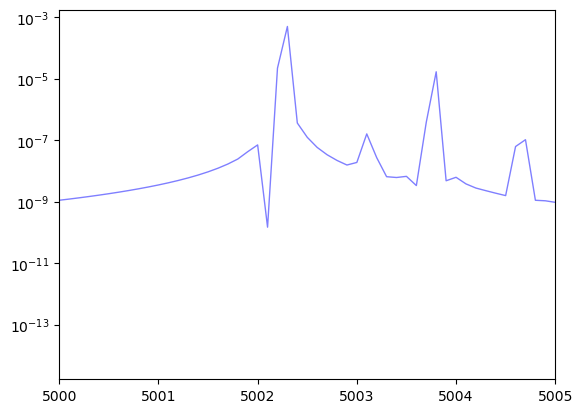

In [14]:
plt.plot(wavelengths, opacity, lw=1, color='blue', alpha=0.5)
plt.yscale('log')
plt.xlim(5000, 5005)

In [15]:
# # === STEP 6: Save results and prepare for comparison ===
# print("\n💾 Saving results...")

# # Calculate peak wavelength
# max_idx = jnp.argmax(opacity)
# peak_wavelength = float(wavelengths[max_idx])

# # Save Jorg results in same format as Korg Julia script
# output_file = "jorg_vald_opacity_results.txt"
# with open(output_file, 'w') as f:
#     f.write("# Jorg VALD Linelist Opacity Results - Range 5000-6000 Å\n")
#     f.write(f"# Linelist: {linelist_file}\n")
#     f.write(f"# Number of lines: {len(lines_data)}\n")
#     f.write(f"# Lines in range: {len(lines_in_range)}\n")
#     f.write(f"# Temperature: {temperature} K\n")
#     f.write(f"# Electron density: {electron_density} cm⁻³\n")
#     f.write(f"# Hydrogen density: {hydrogen_density} cm⁻³\n")
#     f.write(f"# Microturbulence: {microturbulence_kms} km/s\n")
#     f.write("# Wavelength(Å)  Opacity(cm⁻¹)\n")
#     for i, wl in enumerate(wavelengths):
#         f.write(f"{float(wl)}  {float(opacity[i])}\n")

# print(f"💾 Data saved as: {output_file}")

# Load and compare with Korg results if available
korg_file = "korg_vald_opacity_results.txt"
if Path(korg_file).exists():
    print(f"\n🔍 Comparing with Korg results from {korg_file}...")
    
    # Read Korg results
    korg_data = []
    with open(korg_file, 'r') as f:
        for line in f:
            if not line.startswith('#'):
                parts = line.strip().split()
                if len(parts) >= 2:
                    try:
                        wl = float(parts[0])
                        op = float(parts[1])
                        korg_data.append((wl, op))
                    except:
                        pass
    
    print(f"  Loaded {len(korg_data)} Korg data points")
    
    # Find matching wavelengths and compare
    if korg_data:
        korg_wavelengths = jnp.array([d[0] for d in korg_data])
        korg_opacities = jnp.array([d[1] for d in korg_data])
        
        # Calculate statistics on matching points
        korg_max = float(jnp.max(korg_opacities))
        korg_mean = float(jnp.mean(korg_opacities))
        
        print(f"\n📊 Comparison with Korg:")
        print(f"  Jorg maximum opacity: {max_opacity:.3e} cm⁻¹")
        print(f"  Korg maximum opacity: {korg_max:.3e} cm⁻¹")
        print(f"  Ratio (Jorg/Korg): {max_opacity/korg_max:.3f}")
        
        print(f"  Jorg mean opacity: {mean_opacity:.3e} cm⁻¹")
        print(f"  Korg mean opacity: {korg_mean:.3e} cm⁻¹")
        print(f"  Ratio (Jorg/Korg): {mean_opacity/korg_mean:.3f}")
        
        # Check agreement
        if abs(max_opacity/korg_max - 1) < 0.1:
            print("  ✅ Good agreement in maximum opacity!")
        else:
            print("  ⚠️ Significant difference in maximum opacity")
            
else:
    print(f"\n💡 Run the Korg Julia script first to generate {korg_file} for comparison")

print("\n🎉 Jorg opacity calculation completed!")
print("📋 Summary:")
print(f"  • Processed {processed_lines} lines successfully")
print(f"  • Peak opacity: {max_opacity:.3e} cm⁻¹ at {peak_wavelength:.2f} Å")
print(f"  • Calculation time: {calc_time:.2f} seconds")
print(f"  • Ready for comparison with Korg Julia script results")


🔍 Comparing with Korg results from korg_vald_opacity_results.txt...
  Loaded 10001 Korg data points

📊 Comparison with Korg:
  Jorg maximum opacity: 4.986e-04 cm⁻¹
  Korg maximum opacity: 4.864e-06 cm⁻¹
  Ratio (Jorg/Korg): 102.517
  Jorg mean opacity: 5.391e-08 cm⁻¹
  Korg mean opacity: 4.513e-09 cm⁻¹
  Ratio (Jorg/Korg): 11.947
  ⚠️ Significant difference in maximum opacity

🎉 Jorg opacity calculation completed!
📋 Summary:
  • Processed 14 lines successfully
  • Peak opacity: 4.986e-04 cm⁻¹ at 5002.30 Å
  • Calculation time: 0.14 seconds
  • Ready for comparison with Korg Julia script results


(5000.0, 5005.0)

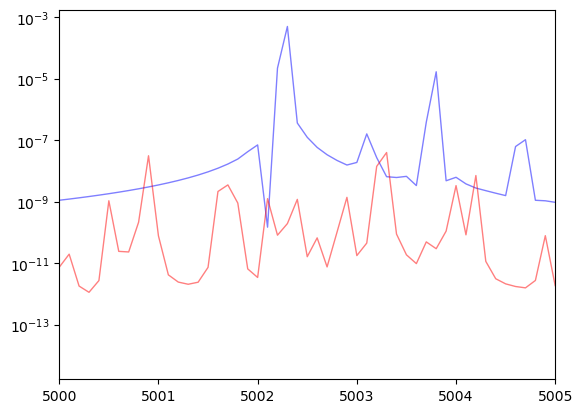

In [16]:
plt.plot(wavelengths, opacity, lw=1, color='blue', alpha=0.5)
plt.plot(korg_wavelengths, korg_opacities, lw=1, color='red', alpha=0.5)
plt.yscale('log')
plt.xlim(5000, 5005)